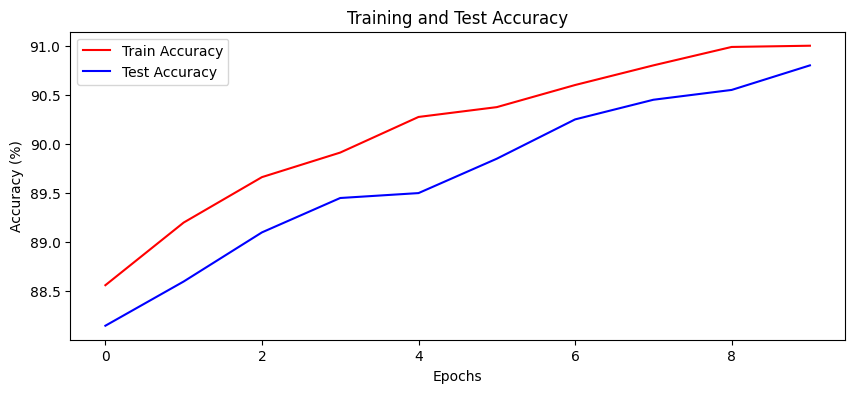

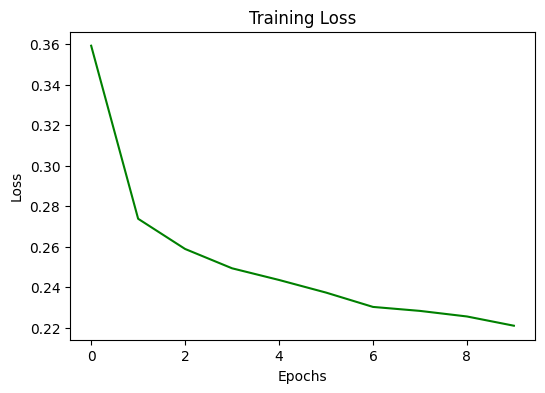

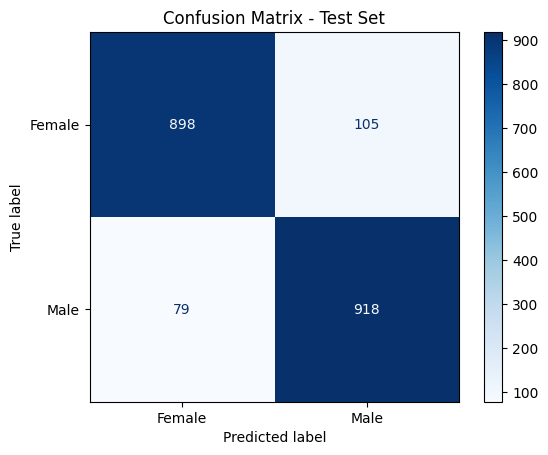

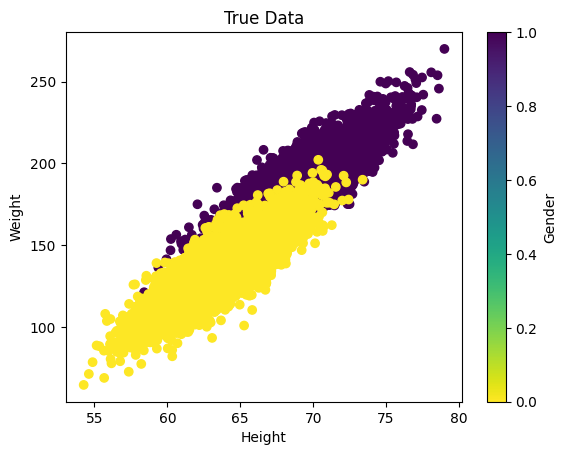

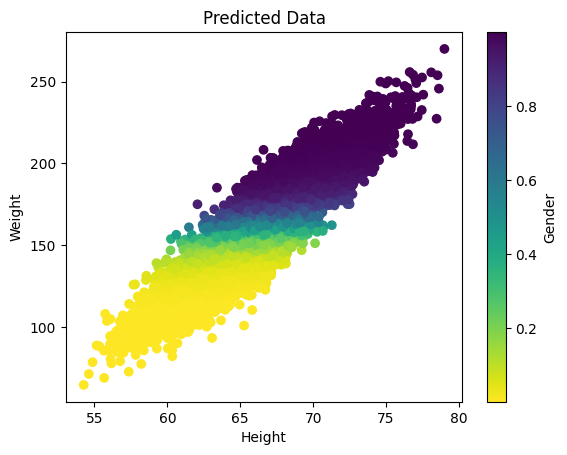

In [3]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 1. Load Dataset
# -----------------------------
url = "https://raw.githubusercontent.com/johnmyleswhite/ML_for_Hackers/master/02-Exploration/data/01_heights_weights_genders.csv"
dataset = pd.read_csv(url)

# Features: Height and Weight
X = np.column_stack((dataset["Height"].values, dataset["Weight"].values))

# Labels: Gender (Male=1, Female=0)
Y = np.array([1 if g == "Male" else 0 for g in dataset["Gender"].values])

# -----------------------------
# 2. Custom Dataset
# -----------------------------
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.x = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(Y, dtype=torch.float32)
        self.length = self.x.shape[0]

        # Standardize features
        self.x = (self.x - self.x.mean(dim=0)) / torch.sqrt(self.x.var(dim=0) + 1e-8)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

# -----------------------------
# 3. DataLoader
# -----------------------------
dataset = CustomDataset(X, Y)
n_test = int(0.2 * len(dataset))
train_set, test_set = random_split(dataset, [len(dataset) - n_test, n_test], generator=torch.Generator().manual_seed(24))

BATCH_SIZE = 150
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

# -----------------------------
# 4. Model Definition
# -----------------------------
input_size = 2
hidden_size = 100

model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

# -----------------------------
# 5. Training Setup
# -----------------------------
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.04)
EPOCHS = 10

# -----------------------------
# 6. Accuracy Function
# -----------------------------
def evaluate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            out = model(x_batch).squeeze()
            correct += (out.round() == y_batch).sum().item()
            total += y_batch.size(0)
    model.train()
    return 100 * correct / total

# -----------------------------
# 7. Training Loop
# -----------------------------
train_accuracies, test_accuracies, train_losses = [], [], []

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch).squeeze()
        loss = loss_function(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(evaluate_accuracy(model, train_loader))
    test_accuracies.append(evaluate_accuracy(model, test_loader))

# -----------------------------
# 8. Plot Accuracy and Loss
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(train_accuracies, label="Train Accuracy", color="red")
plt.plot(test_accuracies, label="Test Accuracy", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_losses, color="green")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# -----------------------------
# 9. Confusion Matrix
# -----------------------------
all_test_x, all_test_y = next(iter(test_loader))
preds = model(all_test_x).squeeze().round().detach()  # detach() added
cm = confusion_matrix(all_test_y.numpy(), preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

# -----------------------------
# 10. Scatter Plot
# -----------------------------
# True data
plt.scatter(X[:,0], X[:,1], c=Y, cmap="viridis_r")
plt.xlabel("Height")
plt.ylabel("Weight")
plt.title("True Data")
plt.colorbar(label="Gender")
plt.show()

# Predicted data
all_x = dataset.x
all_preds = model(all_x).detach().squeeze()
plt.scatter(X[:,0], X[:,1], c=all_preds, cmap="viridis_r")
plt.xlabel("Height")
plt.ylabel("Weight")
plt.title("Predicted Data")
plt.colorbar(label="Gender")
plt.show()
